In [55]:
import pandas as pd
import sys
import numpy as np
import string
import os
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from tsfresh.feature_extraction import MinimalFCParameters


import tsfresh
from tsfresh.feature_extraction import extract_features

from xgboost import XGBRegressor

import matplotlib.pyplot as plt


In [2]:
sys.path.append(os.path.abspath('..'))


In [98]:
import importlib


import board_helpers
from board_helpers.move_info import MoveInfo
from board_helpers.tiles_counter import TilesCounter
from board_helpers.board_consts import TileType
importlib.reload(board_helpers)
importlib.reload(board_helpers.move_info)
importlib.reload(board_helpers.tiles_counter)
importlib.reload(board_helpers.board_consts)



import transformers
from transformers.columns_setter_transformer import ColumnsSetterTransformer
from transformers.extract_set_column_transformer import ExtractSetColumnsTransformer
from transformers.name_dropper_transformer import NameDropperTransformer
from transformers.select_transformer import SelectTransformer
from transformers.select_by_index_transformer import SelectByIndexTransformer
from transformers.series_from_group_transformer import SeriesFromGroupTransformer
from transformers.map_set_transformer import MapSetTransformer
from transformers.one_hot_encoder_transformer import OneHotEncoderTransformer
from transformers.add_to_dict_transformer import AddToDictTransformer
from transformers.get_from_dict_transformer import GetFromDictTransformer
from transformers.select_by_mask_transformer import SelectByMaskTransformer
from transformers.select_features_wrapper import SelectFeaturesWrapper
from transformers.my_turns_transformation import MyTurnsTransformation
from transformers.turns_transformer import TurnsTransformer
importlib.reload(transformers)
importlib.reload(transformers.columns_setter_transformer)
importlib.reload(transformers.extract_set_column_transformer)
importlib.reload(transformers.name_dropper_transformer)
importlib.reload(transformers.select_transformer)
importlib.reload(transformers.select_by_index_transformer)
importlib.reload(transformers.series_from_group_transformer)
importlib.reload(transformers.map_set_transformer)
importlib.reload(transformers.one_hot_encoder_transformer)
importlib.reload(transformers.add_to_dict_transformer)
importlib.reload(transformers.get_from_dict_transformer)
importlib.reload(transformers.select_by_mask_transformer)
importlib.reload(transformers.select_features_wrapper)
importlib.reload(transformers.my_turns_transformation)
importlib.reload(transformers.turns_transformer)


import functions
from functions.bot_extractor import BotExtarctor
from functions.is_bot_extractor import IsBotExtarctor
importlib.reload(functions)
importlib.reload(functions.is_bot_extractor)
importlib.reload(functions.bot_extractor)

import processors
from processors.basic_pre_processor import BasicPreProcessor
importlib.reload(processors)
importlib.reload(processors.basic_pre_processor)

import builders
from builders.preprocessor_builder import PreprocessorBuilder
from builders.reg_pipe_builder import RegPipeBuilder
importlib.reload(builders)
importlib.reload(builders.preprocessor_builder)
importlib.reload(builders.reg_pipe_builder)

import searcher
import searcher_results_orgenizer
from searcher import Searcher
from searcher_results_orgenizer import SearcherResultsOrgenizer
importlib.reload(searcher)
importlib.reload(searcher_results_orgenizer)







<module 'searcher_results_orgenizer' from 'c:\\Users\\Bina4\\Desktop\\Guy_hafifa\\scrabble\\searcher_results_orgenizer.py'>

In [4]:
games = pd.read_csv('../data/games.csv', index_col='game_id')
train = pd.read_csv('../data/train.csv', index_col='game_id')
turns = pd.read_csv('../data/turns.csv', index_col='game_id')
fs_turns = pd.read_csv('../data/fs_turns.csv', index_col='game_id')



In [18]:
G_NAME = 'games'
T_NAME = 'turns'
DATA_NAME = 'train'

names = ['BetterBot', 'STEEBot', 'HastyBot']

features = np.load('../feature_selection_consts/columns.npy', allow_pickle=True)


prePipe = Pipeline([
                    ('get_relavent_turns', SelectByIndexTransformer(train.index.unique(), target=T_NAME)),
                     ('get_relavent_games',  SelectByIndexTransformer(train.index.unique(), target=G_NAME)),
                     ('train_set_is_player', ExtractSetColumnsTransformer({'is_player': IsBotExtarctor(names, 'nickname', True)},
                                                                           src=DATA_NAME, dest=DATA_NAME)),
                     ('get_bot_rating', ExtractSetColumnsTransformer({'bot_rating': lambda train: train[~train['is_player']]['rating']},
                                                                      src=DATA_NAME, dest=G_NAME)),
                     ('get_bots_names', ExtractSetColumnsTransformer({'bot_name': lambda train: train[~train['is_player']]['nickname']},
                                                                     src=DATA_NAME, dest=G_NAME)),
                    ('data_drop_bot_rating', SelectByMaskTransformer('is_player', target=DATA_NAME)),
                    ])
preprocessor = PreprocessorBuilder(games, G_NAME, turns, T_NAME, prePipe).build()
n_games, n_turns, n_ratings = preprocessor.process(train, DATA_NAME)
# t_turns = MyTurnsTransformation().transform(n_turns) # I want to add that to pre later
# n_data = n_games.merge(t_turns, left_index=True, right_index=True)



In [5]:
letters = ['Z', 'A', 'I', '.', 'e', 'l']
names = ['BetterBot', 'STEEBot', 'HastyBot']

initial_pipe = Pipeline([
                ('hot', OneHotEncoderTransformer({'turn_type': turns['turn_type'].unique()})),
                ('count_letters_used',
                MapSetTransformer({letter: (lambda x, letter=letter: x.count(letter) if type(x) == str else 0, 'move') for letter in letters})),
                ('count_tiles_used', 
                ExtractSetColumnsTransformer(
                    {str(t_type): (lambda turns, t_type=t_type: 
                                   turns.apply(lambda x: 
                                               TilesCounter(x['location'], x['move'])()[t_type] if type(x['location'])==str and type(x['move'])==str else 0, axis=1))
                     
                     for t_type in TileType}
                )),
                ('special_tiles', 
                ExtractSetColumnsTransformer(
                    {'special_type': (lambda turns: turns.apply(lambda x: x['TileType.L2'] + x['TileType.L3'] + x['TileType.W2'] + x['TileType.W3'], axis=1))}
                )),
                ('turns_word_info_mappers', MapSetTransformer({'move_len': (lambda x: len(x) if type(x) == str else 0, 'move'), 
                                                               'jokers_num': (lambda x: 
                                                                              sum(1 for c in x if c.islower()) if (type(x) == str) and (x not in ['(challenge)', '(time)']) else 0, 'move'),
                                                }),),
                ('set_is_player', ExtractSetColumnsTransformer({'is_player': IsBotExtarctor(names, 'nickname', True)},)), 
                # ('bool_to_int', ExtractSetColumnsTransformer({'is_player': lambda turns: turns['is_player'].astype(int)})),
                ('drops', NameDropperTransformer(['turn_type', 'nickname', 'move', 'location', 'rack'])),
            ])

In [6]:
fs_turns.columns

Index(['a_turn_type_Challenge__mean', 'a_turn_type_Pass__sum_values',
       'a_turn_type_Timeout__mean', 'a_Z__mean', 'p_points__sum_values',
       'p_points__median', 'p_points__mean', 'p_points__root_mean_square',
       'p_score__root_mean_square', 'p_score__maximum',
       'p_turn_type_End__mean', 'p_turn_type_Exchange__sum_values',
       'p_turn_type_Pass__mean', 'p_turn_type_Pass__standard_deviation',
       'p_turn_type_Play__mean', 'p_A__maximum', 'p_I__maximum', 'p_.__median',
       'p_move_len__mean', 'p_move_len__root_mean_square',
       'p_jokers_num__sum_values', 'p_jokers_num__mean',
       'b_turn_type_End__mean', 'b_e__standard_deviation', 'b_l__mean',
       'b_move_len__sum_values', 'b_jokers_num__mean'],
      dtype='object')

In [87]:
to_mean_std_col = ['points', 'turn_type_Challenge',
       'turn_type_End', 'turn_type_Exchange', 'turn_type_Pass',
       'turn_type_Play', 'turn_type_Six-Zero Rule', 'turn_type_Timeout',
       '.','TileType.N',
       'TileType.L2', 'TileType.L3', 'TileType.W2', 'TileType.W3',
       'special_type', 'move_len', 'jokers_num']

to_max_col = ['points', '.',  'TileType.N',
       'TileType.L2', 'TileType.L3', 'TileType.W2', 'TileType.W3',
       'special_type', 'move_len', 'jokers_num'
]

to_sum_col = ['turn_type_Challenge',
        'turn_type_Exchange', 'turn_type_Pass',
       'turn_type_Play', 'turn_type_Six-Zero Rule', 'turn_type_Timeout',
        '.', 'TileType.N',
       'TileType.L2', 'TileType.L3', 'TileType.W2', 'TileType.W3',
       'special_type', 'move_len', 'jokers_num']

types = ['TileType.N', 'TileType.L2', 'TileType.L3', 'TileType.W2', 'TileType.W3', 'special_type']
mapings = {
             'p_point_dec_weighted_mean': lambda turns: 
                                          turns[turns['is_player']].apply(lambda x: x['points']/np.log(np.ceil(x['turn_number']/2)), axis=1).groupby('game_id').mean(),
             'p_point_inc_weighted_mean': lambda turns:
                                          turns[turns['is_player']].apply(lambda x: x['points'] * np.log(np.ceil(x['turn_number']/2)), axis=1).groupby('game_id').mean(),
             'p_points_by_len_sum': lambda turns: (turns['points']/turns['move_len']).replace([np.inf, -np.inf], np.nan)[turns['is_player']].groupby('game_id').sum(),
              'p_points_by_len_mean': lambda turns: (turns['points']/turns['move_len']).replace([np.inf, -np.inf], np.nan)[turns['is_player']].groupby('game_id').mean(),
              'p_points_max': lambda turns: turns[turns['is_player']]['points'].groupby('game_id').max()

          }
mapings.update({f'p_{name}__mean': lambda turns, name=name: turns[turns['is_player']][name].groupby('game_id').mean()
                for name in types})
mapings.update({f'p_{name}__std': lambda turns, name=name: turns[turns['is_player']][name].groupby('game_id').std()
                for name in types})
# mapings.update({f'p_{name}__mean': lambda turns, name=name: turns[turns['is_player']][name].groupby('game_id').max()
#                 for name in types})
mapings.update({f'p_{name}__sum': lambda turns, name=name: turns[turns['is_player']][name].groupby('game_id').sum()
                for name in types})
mapings.update({f'b_{name}__mean': lambda turns, name=name: turns[~turns['is_player']][name].groupby('game_id').mean()
                for name in types})
# mapings.update({f'a_{name}__mean': lambda turns, name=name: turns[name].groupby('game_id').mean()
#                 for name in types})

In [27]:
i_t_turns = pd.read_csv('../data/my_t_turns.csv', index_col='game_id')

In [88]:
turns_transformer = TurnsTransformer(
                                        # initial_pipe=initial_pipe, 
                                        mappers=mapings
                                    )
t_turns = turns_transformer.transform(i_t_turns)

C:\Users\Bina4\AppData\Local\Temp\ipykernel_2684\682682283.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  turns[turns['is_player']].apply(lambda x: x['points']/np.log(np.ceil(x['turn_number']/2)), axis=1).groupby('game_id').mean(),
C:\Users\Bina4\AppData\Local\Temp\ipykernel_2684\682682283.py:23: RuntimeWarning: invalid value encountered in double_scalars
  turns[turns['is_player']].apply(lambda x: x['points']/np.log(np.ceil(x['turn_number']/2)), axis=1).groupby('game_id').mean(),


In [89]:
n_data = n_games.merge(t_turns, left_index=True, right_index=True).merge(fs_turns, left_index=True, right_index=True)


In [90]:
featureTransformers = [('extract_first', ColumnsSetterTransformer({'is_bot_first': IsBotExtarctor(names, name_col='first')})),
                       ('hot', OneHotEncoderTransformer({'time_control_name': games['time_control_name'].unique(),
                                                          'game_end_reason':  games['game_end_reason'].unique(),
                                                          'lexicon':  games['lexicon'].unique(),
                                                          'rating_mode':  games['rating_mode'].unique(),
                                                          'bot_name': names}
                                                        )),
                      #  ('select_col', SelectTransformer(features)),
                       ('dropper', NameDropperTransformer(
                                    [
                                    'first', 'time_control_name', 'game_end_reason', 'created_at',
                                    'lexicon', 'rating_mode','bot_name',
                                    'time_control_name_nan','game_end_reason_nan' ,'lexicon_nan', 'rating_mode_nan', 'bot_name_nan',
                                    # 'bot_rating'
                                    ])),
                       # add regressor                                              
                      ]

reg_pipe = Pipeline(featureTransformers)
trans = reg_pipe.transform(n_data)

In [91]:
reg = XGBRegressor(random_state=0,
                    max_depth=7, min_child_weight=1,
                    gamma=0,
                    subsample=1, colsample_bytree=1,
                    reg_alpha=0.00005, reg_lambda=1,
                    learning_rate=np.sqrt(3)/10
                    )
reg.fit(trans, n_ratings)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.17320508075688773,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [94]:
cv_res = cross_validate(reg, trans[n_ratings != 1500], n_ratings[n_ratings != 1500], cv=5,
                         scoring=('neg_root_mean_squared_error'),
                         return_train_score=True,)

In [95]:
pd.DataFrame(cv_res).mean()


fit_time         7.886166
score_time       0.106906
test_score    -114.807731
train_score    -86.822120
dtype: float64

In [37]:
n_ratings[n_ratings > 1800]

game_id
3        1811
6        2029
8        2067
10       1838
13       2017
         ... 
72759    2014
72764    1828
72765    2109
72766    2072
72773    2075
Name: rating, Length: 26354, dtype: int64

In [ ]:
i_t_turns[i_t_turns['is_player']].loc[3].plot.scatter(x='turn_number', y='points')

In [63]:
n_ratings[n_ratings > 1800].index[:64]

Int64Index([  3,   6,   8,  10,  13,  15,  16,  18,  19,  20,  22,  24,  25,
             26,  29,  31,  33,  35,  36,  37,  38,  42,  43,  46,  47,  48,
             49,  50,  53,  58,  64,  71,  72,  75,  76,  77,  80,  84,  89,
             97,  99, 106, 109, 111, 112, 113, 114, 116, 118, 123, 126, 127,
            128, 134, 136, 146, 148, 149, 153, 154, 157, 159, 169, 179],
           dtype='int64', name='game_id')

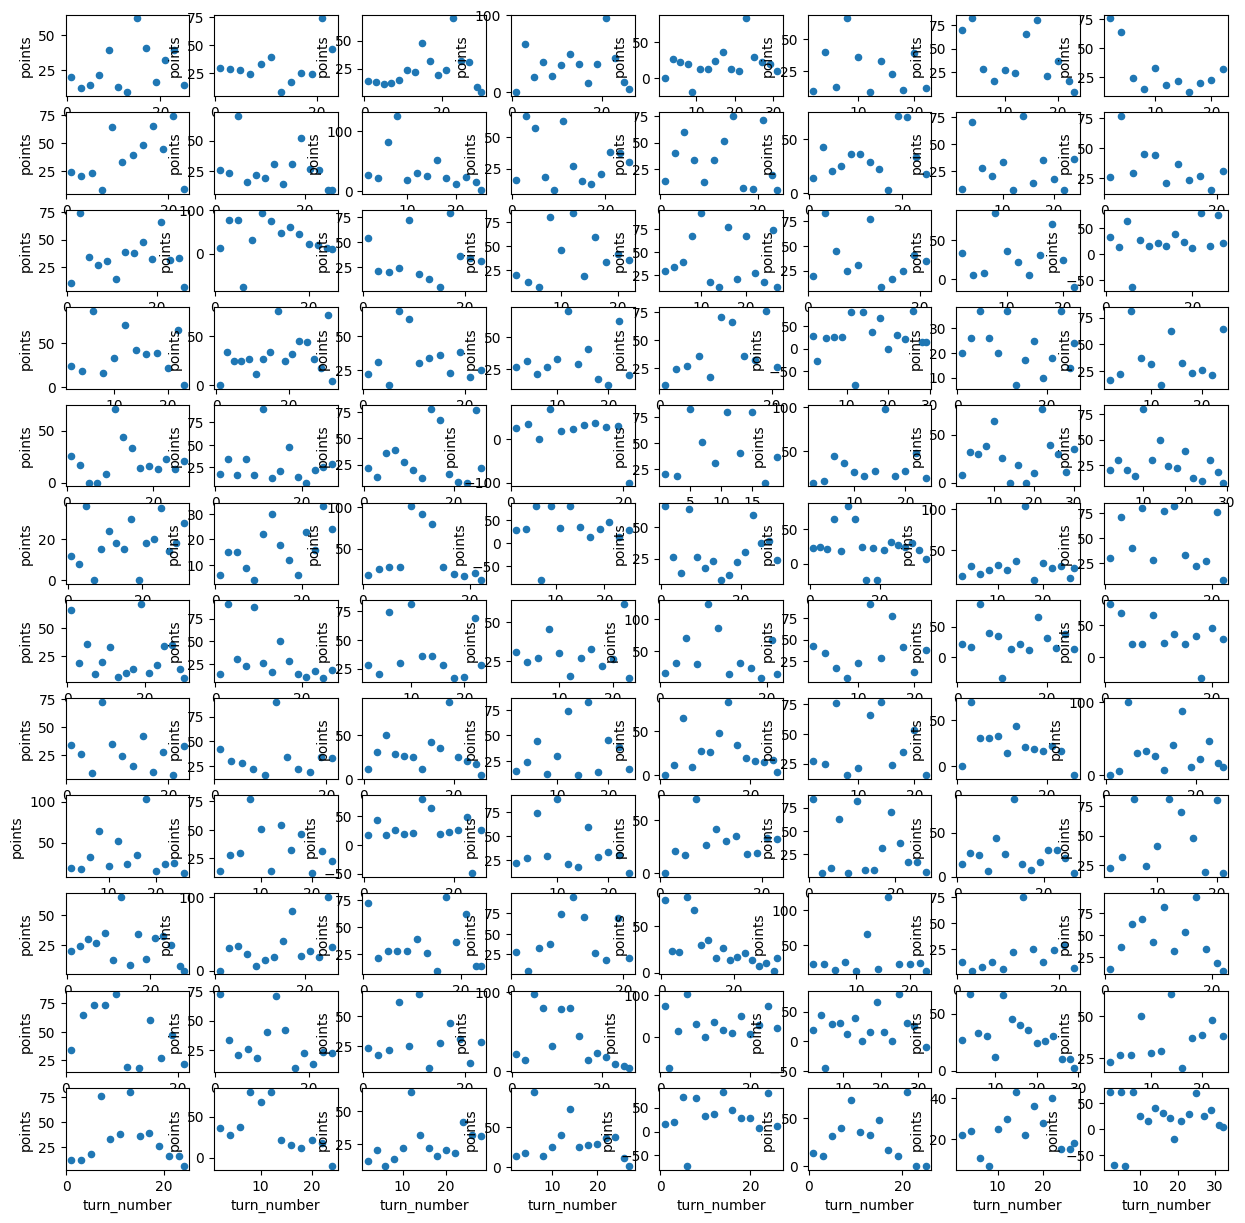

In [77]:
fig, axes = plt.subplots(nrows=12, ncols=8, figsize=(15, 15))
for i, id in enumerate(np.random.permutation(n_ratings[n_ratings > 1800].index[:12 * 8])):
    i_t_turns[i_t_turns['is_player']].loc[id].plot.scatter(x='turn_number', y='points', ax=axes[int(np.floor(i/8)), i%8])

In [70]:
(n_ratings <= 1500).sum()

10036

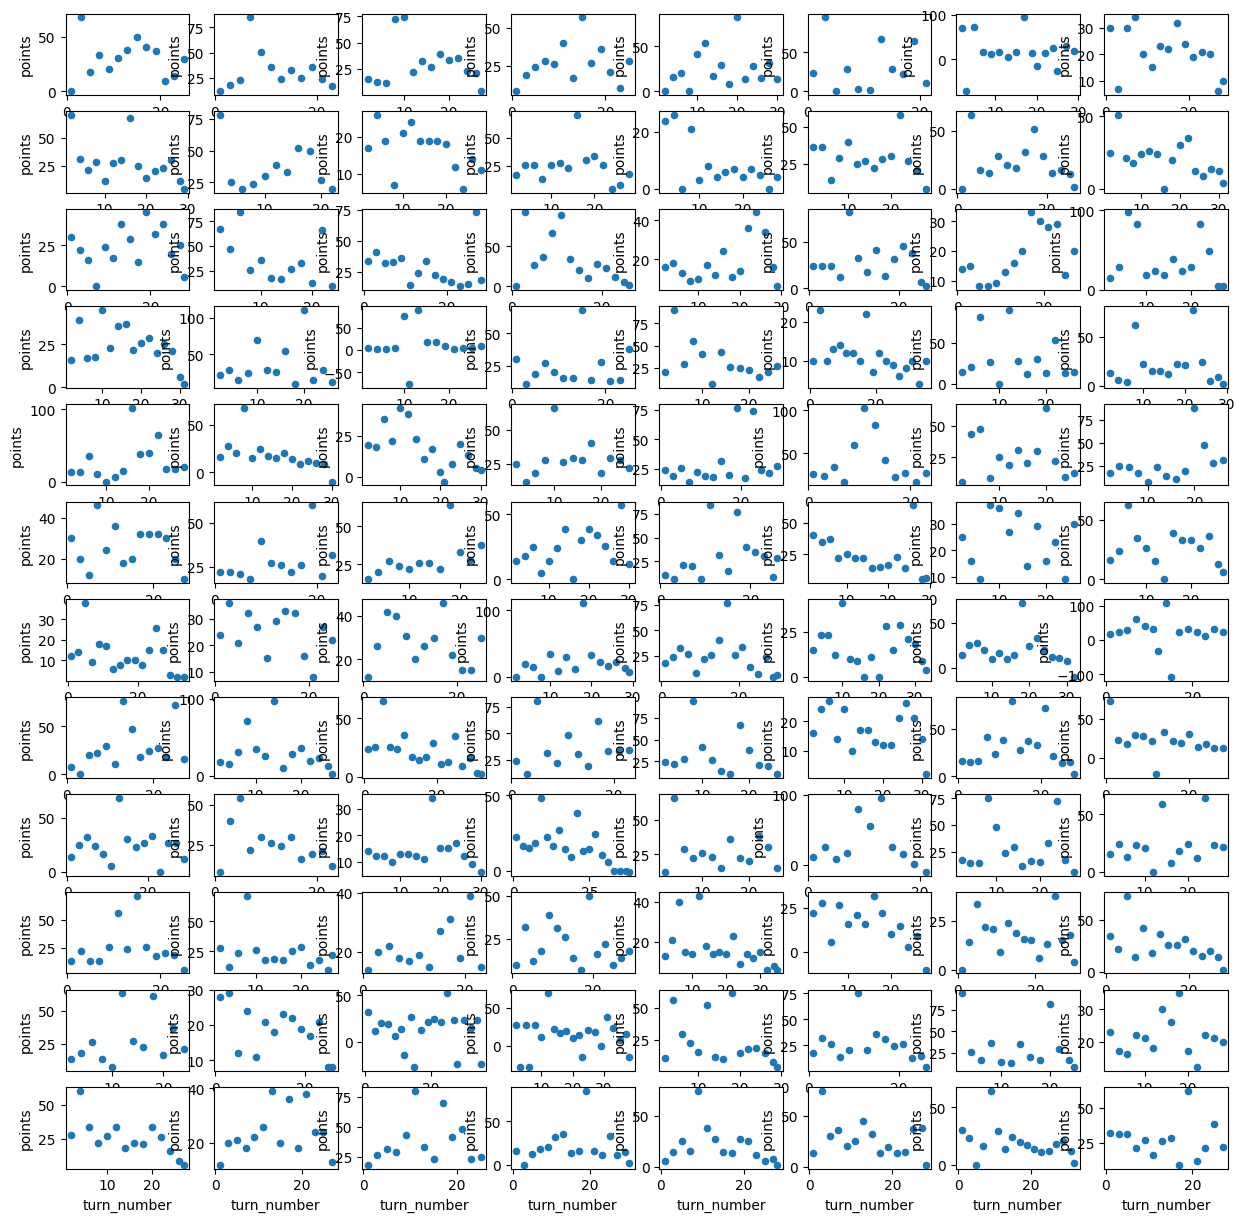

In [78]:
fig, axes = plt.subplots(nrows=12, ncols=8, figsize=(15, 15))
for i, id in enumerate(np.random.permutation(n_ratings[n_ratings <= 1500].index[:12 * 8])):
    i_t_turns[i_t_turns['is_player']].loc[id].plot.scatter(x='turn_number', y='points', ax=axes[int(np.floor(i/8)), i%8])